# Modified IQAE tests

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os
import yaml
import csv
import datetime
import itertools
from tqdm import tqdm

from random import sample, seed
from collections import defaultdict

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, transpile, assemble
from qiskit.algorithms import amplitude_estimators, EstimationProblem
from qiskit.algorithms import IterativeAmplitudeEstimation as BaseIterativeAmplitudeEstimation

from algorithms import IterativeAmplitudeEstimation, ModifiedIterativeAmplitudeEstimation
from algorithms import NoQuantumIterativeAmplitudeEstimation
from operators import *

KeyboardInterrupt: 

In [ ]:
# load config 

with open('./config.yaml') as f:
    config = yaml.safe_load(f)
    
# add default arguments if not already there
defaults = {
    'experiment_name': '{}_modified-iqae',
    'results_path': './results/{}',
    'simulator': 'aer_simulator',
    'compare': True,
    'noise': 0.0,
    'plots': True,
    'verbose': False,
}

now = datetime.datetime.now(datetime.timezone.utc).strftime('%Y-%m-%dT%H%M%SZ')
defaults['experiment_name'] = defaults['experiment_name'].format(now)
defaults['results_path'] = defaults['results_path'].format(defaults['experiment_name'])

for key in defaults:
    if key not in config:
        config[key] = defaults[key]

# process parameters from config

runs = config['runs']
shots = config['shots']
N = config['a_resolution']
step = config['a_step']
alpha = config['alpha']
epsilons = config['epsilons']
confint_method = config['confint_method']
noise = config['noise']
experiment_name = config['experiment_name']
results_path =  config['results_path']
simulator = config['simulator']
compare = config['compare']
plots = config['plots']
verbose = config['verbose']

# maybe some other error checking for when it's done
# especially for ensuring amplitude is [0,1]

if isinstance(step, int):
    amplitudes = np.arange((N // step)+1) * step
else:
    amplitudes = step
    
epsilons = [float(eps) for eps in epsilons]

if confint_method == 'all':
    methods = ['chernoff', 'beta']
else:
    methods = [confint_method]

algs = ['miae']
if compare:
    algs.append('iae')
    
results_per_round_path = os.path.join(results_path, 'per_round')

if not os.path.exists('./results'):
    os.mkdir('./results')
if not os.path.exists(results_path):
    os.mkdir(results_path)
if not os.path.exists(results_per_round_path):
    os.mkdir(results_per_round_path)

## Compare Modified IQAE to No-Quantum IQAE

In [ ]:
# define the estimation problem and oracle function
def make_problem(n, marked):
    
    def good_state(state):
        bin_marked = [(n-len(bin(s))+2)*'0'+bin(s)[2:] for s in marked]
        return (state in bin_marked)

    problem = EstimationProblem(
        state_preparation=A(n),        # A operator
        grover_operator=Q(n, marked),  # Q operator
        objective_qubits=range(n),
        is_good_state=good_state       # the "good" state Psi1 is identified as measuring |1> in qubit 0
    )
    
    return problem

# process the per-round info
def process_state(state, verbose=False):
    if verbose:
        for k,v in state.items():
            print(k)
            print(v)
    if len(state) == 0: return [],[],[]
    round_shots = state['round_shots']
    queries = state['n_queries']
    removed = False

    if 0 in round_shots:
        shots_at_k0 = round_shots.pop(0)
        removed = True
    if 0 in queries:
        queries_at_k0 = queries.pop(0)

    k_i = [k for k in round_shots]
    queries_i = [queries[k] for k in k_i]
    shots_i = ([shots_at_k0] if removed else []) + [round_shots[k] for k in k_i]

    if removed:
        k_i.insert(0, 0.1)

    return shots_i, queries_i, k_i

In [ ]:
def experiment(alg: str, shots: int, M: int, N: int, alpha: float, 
               epsilon: float, confint_method: str, noise: float, 
               runs: int, simulator: str):

    AE = None
    if alg == 'miae':
        AE = ModifiedIterativeAmplitudeEstimation(epsilon_target=epsilon, 
                                                  alpha=alpha, 
                                                  confint_method=confint_method, 
                                                  quantum_instance=simulator)

    else: # alg == 'iae'
        AE = IterativeAmplitudeEstimation(epsilon_target=epsilon, 
                                          alpha=alpha,
                                          confint_method=confint_method, 
                                          quantum_instance=simulator)

        
    n = int(np.log2(N))
    marked = sample(range(N), M)
    problem = make_problem(n, marked)
    ae_results = []

    for _ in range(runs):        
    
        # setup
        state = defaultdict(dict)
        scaling = 1 # figure out what to do here

        if noise > 0:
            N = max(128, N * scaling) # replace with the correct formula
            n = int(np.log2(N))
            sampled_noise = np.random.uniform(-noise if M > N else 0, noise if M < N else 0)
            scaled_noisy_M = int(max(0, min(N, (M + sampled_noise) * scaling)))

            marked = sample(range(N), scaled_noisy_M)
            problem = make_problem(n, marked)
            
            # scale back to original resolution
            noisy_M = scaled_noisy_M / scaling
            N = config['a_resolution']
            n = int(np.log2(N))
            
        # run estimation
        ae_result = AE.estimate(problem,
                                shots=shots,
                                ground_truth=noisy_M/N if noise > 0 else M/N,
                                state=state,
                                verbose=verbose)
        
        ae_results.append(ae_result)

        if verbose: print()

        # round-specific logs
        round_shots, round_queries, round_k = process_state(state)

        round_results_csv = os.path.join(results_per_round_path, f'{M/N}_{confint_method}_{epsilon:.1e}_{alg}_round-results.csv')

        with open(round_results_csv, 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(['round_shots'] + round_shots)
            writer.writerow(['round_queries'] + round_queries)
            writer.writerow(['round_k'] + round_k)

    # experiment-specific logs
    half_ci_widths = np.array([(res.confidence_interval_processed[1] - res.confidence_interval_processed[0]) / 2 for res in ae_results])
    queries = np.array([res.num_oracle_queries for res in ae_results])
    estimations = np.array([res.estimation for res in ae_results])

    results_csv = os.path.join(results_path, f'{M/N}_{confint_method}_{alg}_results.csv')

    with open(results_csv, 'a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([epsilon] + queries.tolist())
    
    if verbose:
        print(f'Results using algorithm \'{alg}\', amplitude {M}/{N} = {M/N}', end='')
        print(f' (with noise: {noisy_M/N})' if noise > 0 else '', end=' ')
        print(f'averaged over {runs} runs:')
        print(f'\tEstimation: {round(estimations.mean(), 10)}')
        print(f'\tTotal queries: {round(queries.mean())}')
        print(f'\tCI width: {half_ci_widths.mean()}')

        

        #     n_entries = 0
        #     for confint_method in ['chernoff', 'beta']:

        #         if verbose:
        #             print('ε:',epsilon)

                # configure the number of shots this way and pray that it works
        

        # for recording intermediate algo results
        

#                 miae_result = MIAE.estimate(problem,
#                                             state=state,
#                                             verbose=verbose)

#                 iae_result = IAE.estimate(problem2,
#                                           state=state2,
#                                           verbose=verbose)

#                 miae_results[confint_method].append(miae_result)
#                 iae_results[confint_method].append(iae_result)

#                 if verbose:
#                     print()

                
#                 base_shots, base_queries, base_k = process_state(state2)




        
#         if plots:
#             # process results
#             plt.figure(figsize=(15,7))
#             plt.yscale('log')
#         #     plt.ylim(10**4, 10**10)
#             plt.xscale('log')

#             plt.xlim(epsilons[0]*2, epsilons[-1]/2)
#             plt.title(f'{"Noisy " if add_noise else ""}Error vs. Number of Queries')

#         miae_epsilon_i = {}
#         miae_nshots_i = {}
#         iae_epsilon_i = {}
#         iae_nshots_i = {}
        
#         for confint_method in ['chernoff', 'beta']:
#             miae_epsilon_i[confint_method] = [(res.confidence_interval_processed[1] - res.confidence_interval_processed[0]) / 2 for res in miae_results[confint_method]]
#             miae_nshots_i[confint_method]  = [res.num_oracle_queries for res in miae_results[confint_method]]

#             iae_epsilon_i[confint_method] = [(res.confidence_interval_processed[1] - res.confidence_interval_processed[0]) / 2 for res in iae_results[confint_method]]
#             iae_nshots_i[confint_method]  = [res.num_oracle_queries for res in iae_results[confint_method]]

#             if verbose:
#                 print(f'a: {ki}/{2**n} = {ki/2**n}')
#                 print(f'{exprs[0]} estimations:', [res.estimation for res in miae_results[confint_method]])
#                 print(f'{exprs[1]} estimations:', [res.estimation for res in iae_results[confint_method]])

#             miae_total_queries, iae_total_queries = sum(miae_nshots_i[confint_method]), sum(iae_nshots_i[confint_method])
            
#             if verbose:
#                 print(f'{exprs[0]} total queries:', miae_total_queries)
#                 print(f'{exprs[1]} total queries:', iae_total_queries)

#                 print(f'{exprs[0]} epsilons (CI width):', miae_epsilon_i)
#                 print(f'{exprs[1]} epsilons (CI width):', iae_epsilon_i)

#             diff = round(abs(iae_total_queries - miae_total_queries) / miae_total_queries * 100, 2)
#         #     print('Modified version wins?', iae_total_queries < miae_total_queries, f'with {diff}% difference')

#             wins += int(iae_total_queries < miae_total_queries)
#             matches += 1

#             if plots:
#                 # plots for query complexity, shots per k

#                 # plot query complexity
#                 plt.scatter(epsilons, miae_nshots_i[confint_method])
#                 plt.plot(epsilons, miae_nshots_i[confint_method], label=f'{confint_method.title()} modified')
#                 plt.scatter(epsilons, iae_nshots_i[confint_method])
#                 plt.plot(epsilons, iae_nshots_i[confint_method], label=f'{confint_method.title()} base')

#         if plots:
#             plt.legend()
#             plt.show()

#         # save results for epsilon vs nshots
#         miae_nshots.append(miae_nshots_i)
#         miae_epsilon.append(miae_epsilon_i)
#         iae_nshots.append(iae_nshots_i)
#         iae_epsilon.append(iae_epsilon_i)

#         ki += 1

# #     iae_nshots = np.array(iae_nshots)
    
#     return { 
#         'miae_nshots': miae_nshots, 
#         'miae_epsilon': miae_epsilon,
#         'iae_nshots': iae_nshots,
#         'iae_epsilon': iae_epsilon
#     }

    # print('% modified > 3x modified:', wins/matches)

In [ ]:
experiment_combos = list(itertools.product(algs, amplitudes, epsilons, methods))
print('Experiment configuration size:', len(experiment_combos))
print('# runs per configuration:', runs)
print('Total runs:', len(experiment_combos) * runs)

# re-save the config into the file
with open(os.path.join(results_path, 'config.yaml'), 'w') as out:
    yaml.dump(config, out)
    
for alg, M, epsilon, method in tqdm(experiment_combos):
    experiment(alg, shots, M, N, alpha, epsilon, method, noise, runs, simulator)
    

# Query complexity

In [121]:
def pad_matrix(arr):
    max_len = len(max(arr, key=lambda x: len(x)))

    padded = np.zeros((len(arr), max_len), dtype=int)

    for i in range(len(arr)):
        padded[i:i + 1, 0:len(arr[i])] = arr[i]
        
    return padded
    

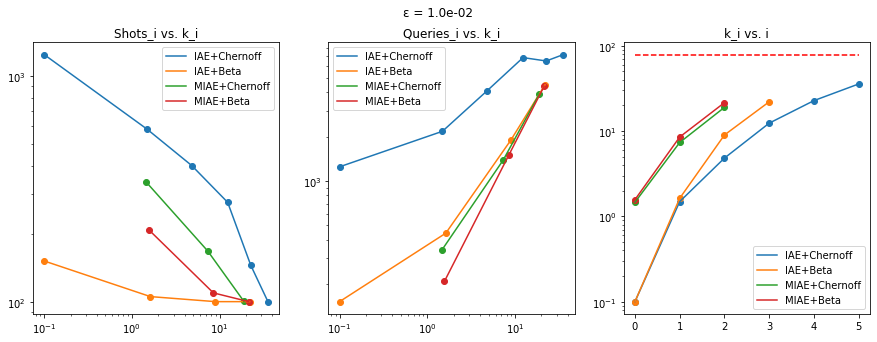

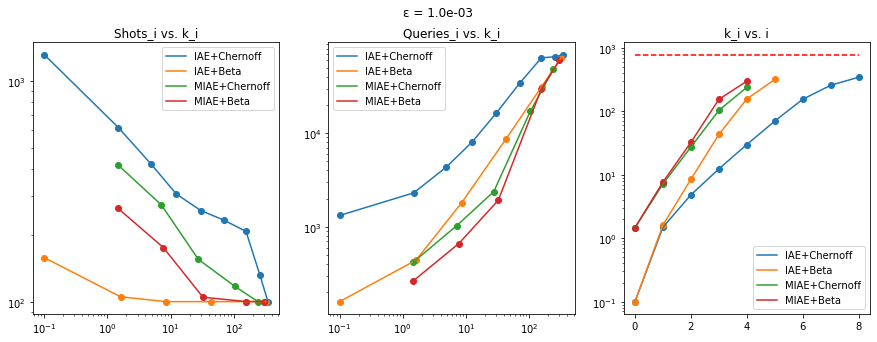

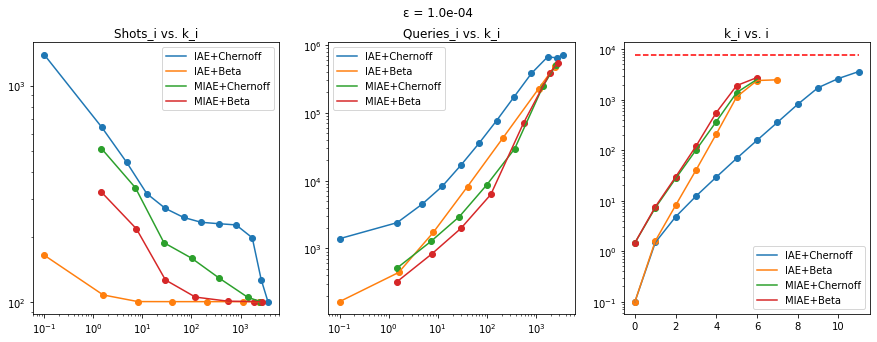

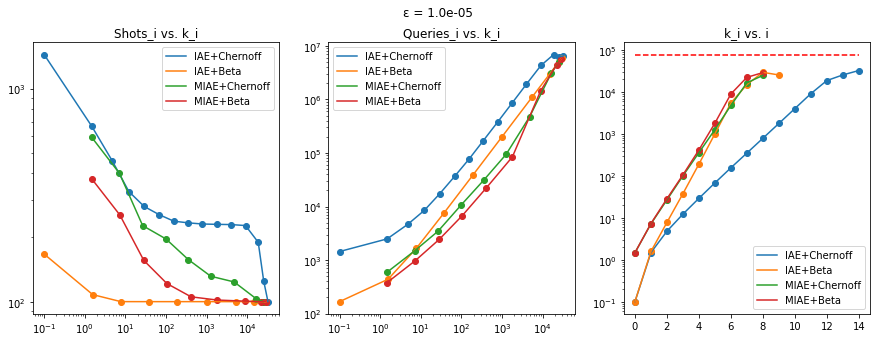

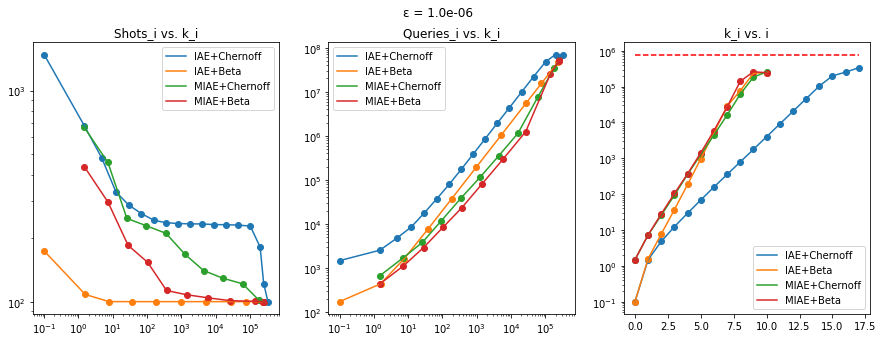

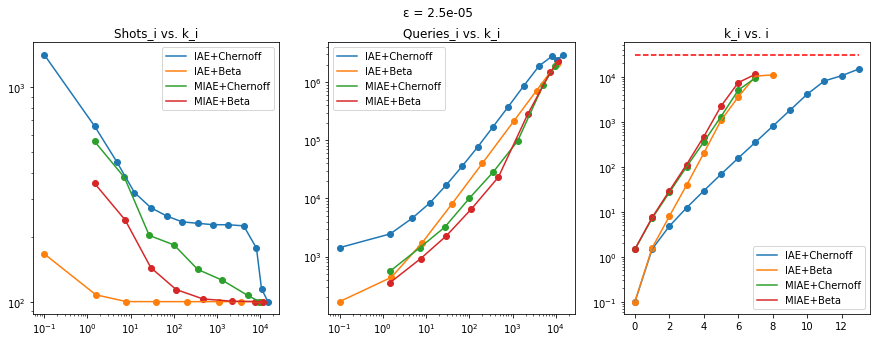

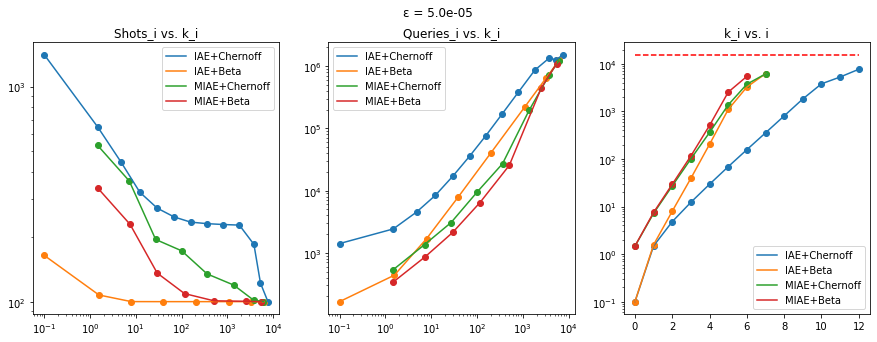

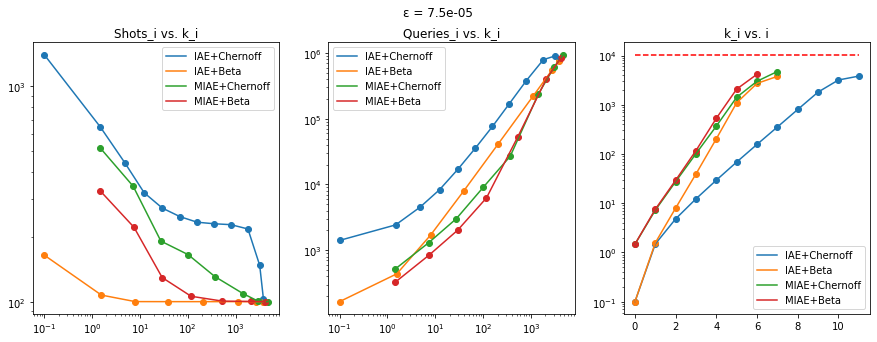

In [152]:

# load per-round files
per_round_path = os.path.join('results/2022-07-15T234959Z_modified-iqae', 'per_round')
per_round_stats = []

for csv_name in os.listdir(per_round_path):
    csv_path = os.path.join(per_round_path, csv_name)
    if not os.path.isfile(csv_path): continue
    confint_method, epsilon, alg = csv_name.split('_')[1:4]

    with open(csv_path) as f:
        rows = csv.reader(f)
        for csv_row in rows:
            df_row = [confint_method, epsilon, alg, csv_row[0], np.array([float(x) for x in csv_row[1:]])]
            per_round_stats.append(df_row)

per_round_df = pd.DataFrame(per_round_stats, columns=['confint_method', 'epsilon', 'alg', 'field', 'data'])
fields = per_round_df['field'].unique()

for epsilon, df_epsilon in per_round_df.groupby(['epsilon']):

    fig, axs = plt.subplots(1, 3, figsize=(15,5))
    fig.suptitle(f'ε = {epsilon}')
    axs[0].set_xscale('log')
    axs[0].set_yscale('log')
    axs[0].set_title('Shots_i vs. k_i')

    axs[1].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].set_title('Queries_i vs. k_i')

    axs[2].set_yscale('log')
    axs[2].set_title('k_i vs. i')

    n_entries = 0
    
    for (alg, confint_method), df_alg_confint in sorted(df_epsilon.groupby(['alg', 'confint_method']), 
                                                        key=lambda x: (x[0][0], -ord(x[0][1][0]))):
    
        
        avg_stats = {}

        for field in fields:
            padded_stats = pad_matrix(df_alg_confint[df_alg_confint['field'] == field]['data'].to_numpy().tolist())
            div = np.count_nonzero(padded_stats, axis=0)
            div[div == 0] = 1 # suppress divide by zero
            avg_stats[field] = padded_stats.sum(axis=0) / div
            avg_stats[field][avg_stats[field] == 0] = 0.1 # for adding zero to log plots
            
        n_entries = max(n_entries, len(avg_stats['round_k']))
        label = f'{alg.upper()}+{confint_method.title()}'

        # plots for shots vs k
        axs[0].plot(avg_stats['round_k'], avg_stats['round_shots'], label=label)
        axs[0].scatter(avg_stats['round_k'], avg_stats['round_shots'])

        # plots for nqueries vs k
        axs[1].plot(avg_stats['round_k'], avg_stats['round_queries'], label=label)
        axs[1].scatter(avg_stats['round_k'], avg_stats['round_queries'])

        # plots for k
        axs[2].plot(avg_stats['round_k'], label=label)
        axs[2].scatter(range(len(avg_stats['round_k'])), avg_stats['round_k'])

    for i in range(3): axs[i].legend()

    axs[2].plot(range(n_entries), np.repeat(np.pi / 4 / float(epsilon), n_entries), c='r', linestyle='--')
    
    plt.savefig()
    plt.close()
    plt.show()

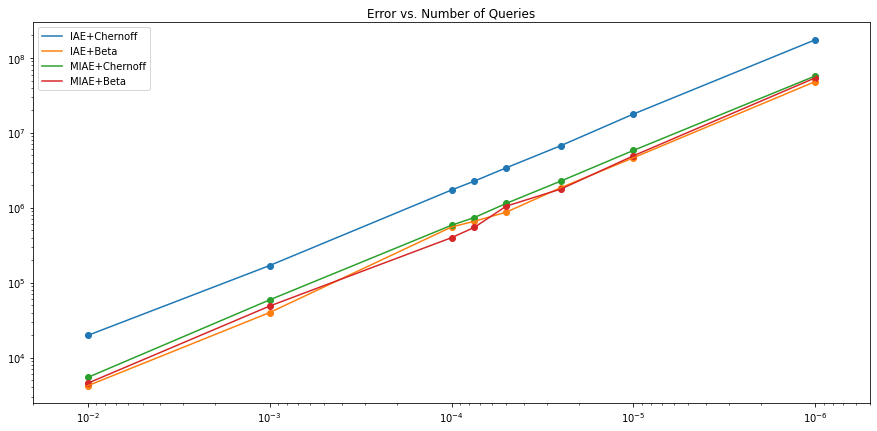

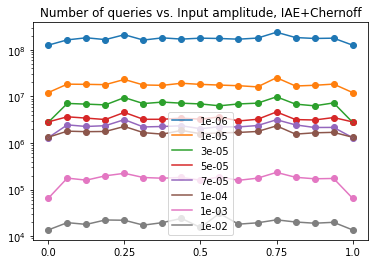

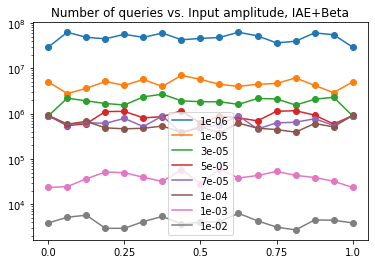

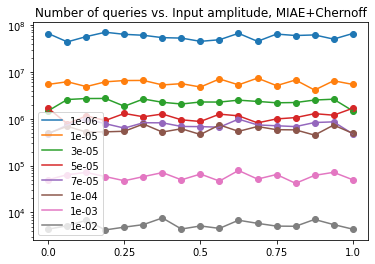

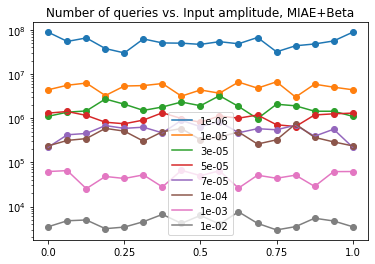

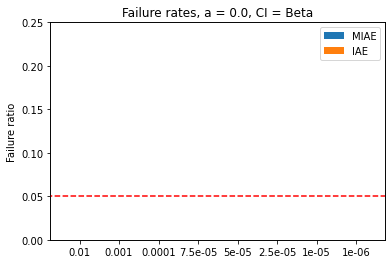

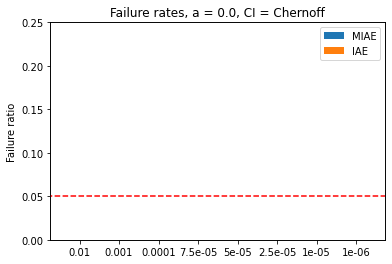

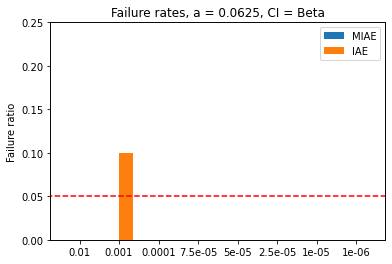

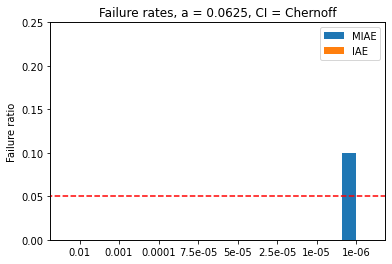

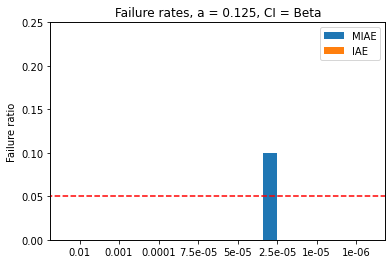

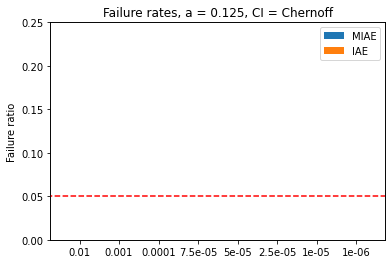

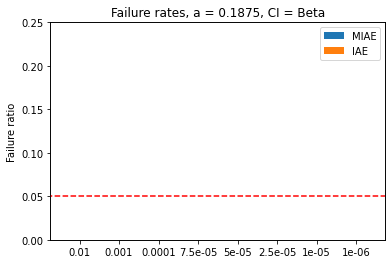

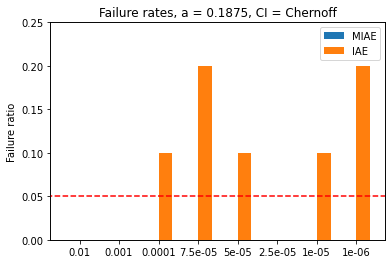

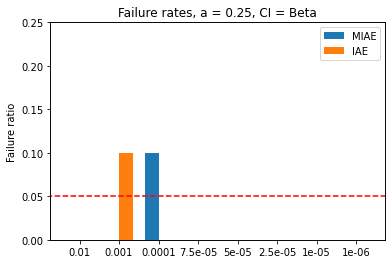

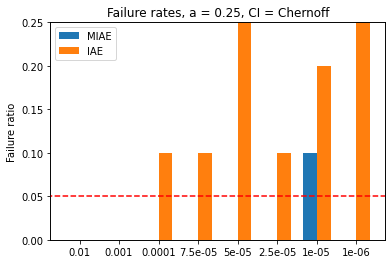

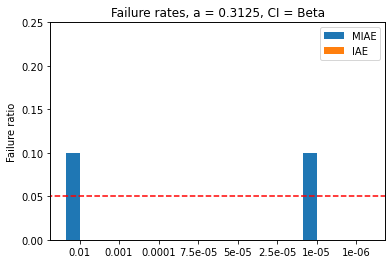

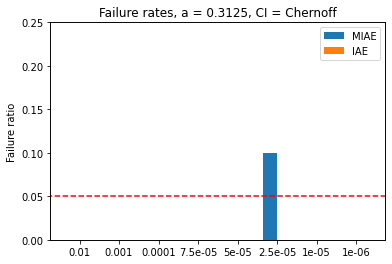

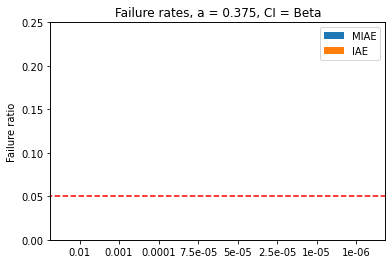

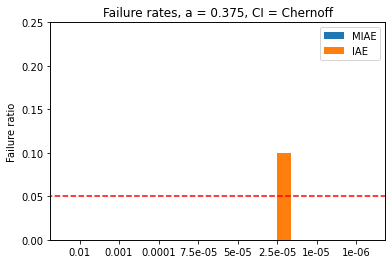

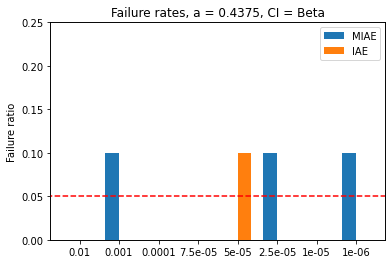

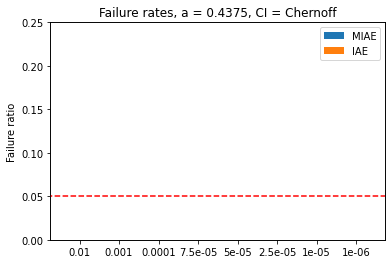

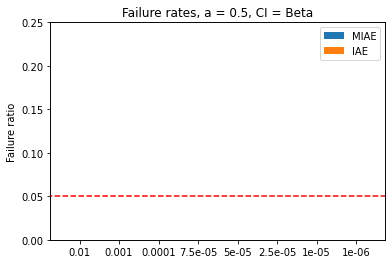

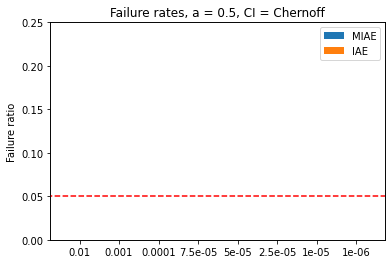

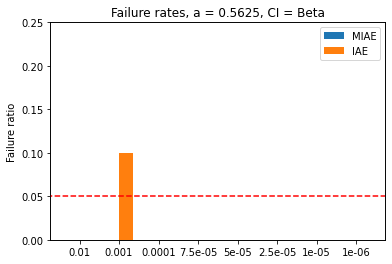

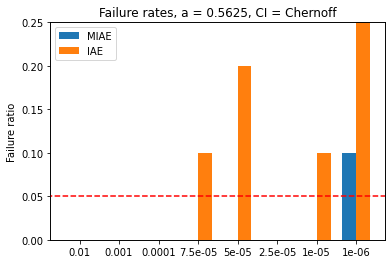

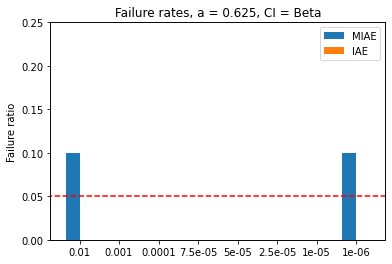

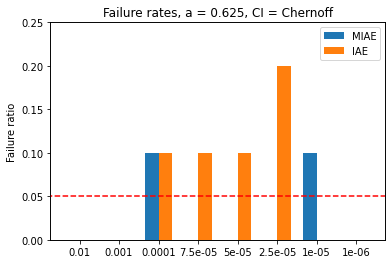

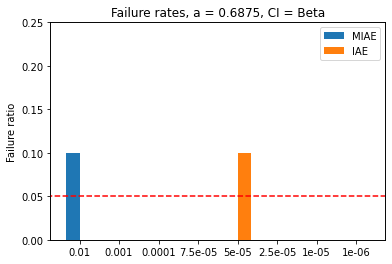

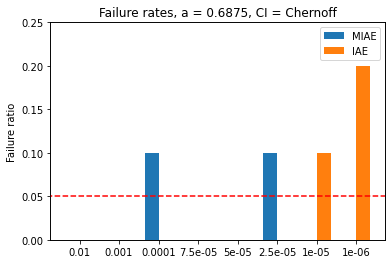

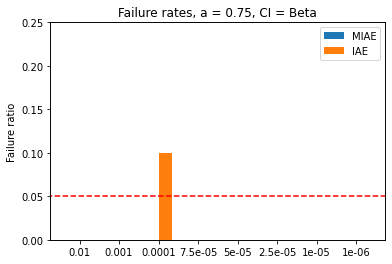

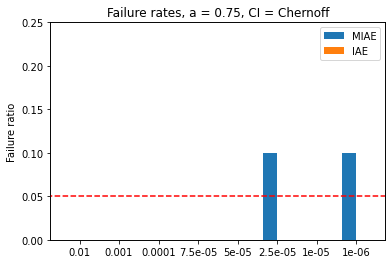

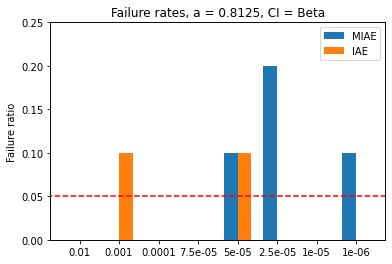

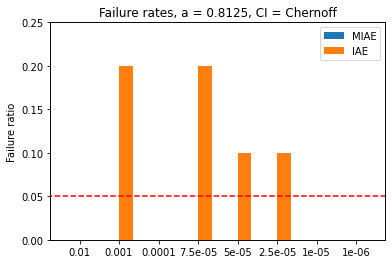

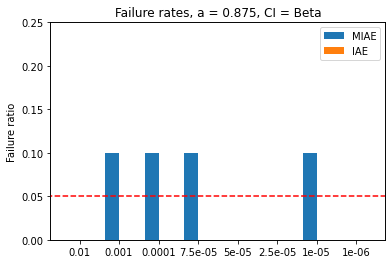

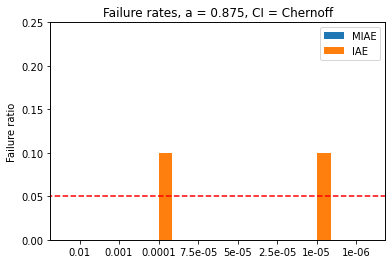

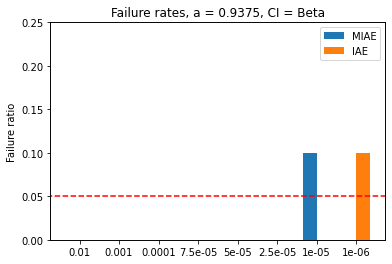

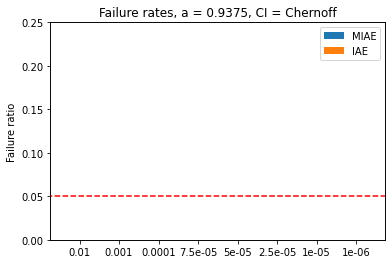

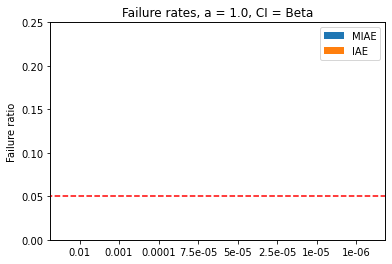

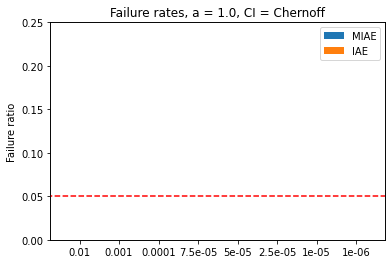

In [222]:
test = 'results/2022-07-18T030550Z_modified-iqae'

# overall query complexity and failure rate
df_rows = []

for csv_name in os.listdir(test):
    csv_path = os.path.join(test, csv_name)
    if os.path.splitext(csv_name)[1] != '.csv': continue
    amplitude, confint_method, alg = csv_name.split('_')[:3]

    with open(csv_path) as f:
        rows = csv.reader(f)
        for csv_row in rows:
            epsilon, failure, data = float(csv_row[0]), float(csv_row[1]), np.array([int(x) for x in csv_row[2:]]).mean()
            df_rows.append([alg, confint_method, epsilon, amplitude, data, failure])


df = pd.DataFrame(df_rows, columns=['alg', 'confint_method', 'epsilon', 'amplitude', 'data', 'failure'])
complexity = defaultdict(lambda: defaultdict(list))

for (alg, confint_method, epsilon), df_i in sorted(df.groupby(['alg', 'confint_method', 'epsilon']), 
                                                   key=lambda x: (-x[0][2], x[0][0], -ord(x[0][1][0]))):
    complexity[(alg,confint_method)]['epsilon'].append(epsilon)
    complexity[(alg,confint_method)]['queries'].append(df_i['data'].mean())

plt.figure(figsize=(15,7))
plt.xscale('log')
plt.yscale('log')

plt.xlim(1e-2*2, 1e-6/2) # hardcoded
plt.title('Error vs. Number of Queries')

for (alg, confint_method), data in complexity.items():
    epsilon, queries = data['epsilon'], data['queries']
    plt.scatter(epsilon, queries)
    plt.plot(epsilon, queries, label=f'{alg.upper()}+{confint_method.title()}')

plt.legend()

# plt.savefig(f'results_images/err-vs-queries_{a}-{k}.png')
plt.show()

# make another one for zoomed in, without log scaling


# Query count vs. input amplitude

amplitude_query = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

for (alg, confint_method, amplitude, epsilon), df_i in sorted(df.groupby(['alg', 'confint_method', 'amplitude', 'epsilon']), 
                                                              key=lambda x: (x[0][2], x[0][0], -ord(x[0][1][0]))):
    
    amplitude_query[(alg, confint_method)][epsilon]['amplitudes'].append(amplitude)
    amplitude_query[(alg, confint_method)][epsilon]['queries'].append(df_i['data'].mean())

for (alg, confint_method) in amplitude_query:
    plt.figure()
    plt.yscale('log')
    
    for epsilon in amplitude_query[(alg, confint_method)]:
        amplitudes = amplitude_query[(alg, confint_method)][epsilon]['amplitudes']
        queries = amplitude_query[(alg, confint_method)][epsilon]['queries']
        plt.plot(amplitudes, queries, label='{:.0e}'.format(epsilon))
        plt.scatter(amplitudes, queries)
    plt.legend()
    plt.title(f'Number of queries vs. Input amplitude, {alg.upper()}+{confint_method.title()}')
    
    locs,labels = plt.xticks()
    plt.xticks(range(0, locs[-1]+1, 4)) # make more flexible
    
    plt.show()


# Failure rate
        
for (amplitude, confint_method), df_i in sorted(df.groupby(['amplitude', 'confint_method'])):
    
    x = np.arange(len(df_i['epsilon']) // 2)  # the label locations
    width = 0.35  # the width of the bars
    
    miae_failures = df_i[df_i['alg'] == 'miae']['failure']
    iae_failures = df_i[df_i['alg'] == 'iae']['failure']
    
    rects1 = plt.bar(x - width/2, miae_failures, width, label='MIAE')
    rects2 = plt.bar(x + width/2, iae_failures, width, label='IAE')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    plt.ylabel('Failure ratio')
    plt.title((f'Failure rates, a = {amplitude}, CI = {confint_method.title()}'))
    plt.xticks(x, df_i[df_i['alg'] == 'miae']['epsilon'])
    plt.ylim(0,0.25)

    plt.legend()

    ax = plt.twiny()
    line_xs = np.arange(len(df_i[df_i['alg'] == 'miae']['epsilon'])+3) - 2

    ax.plot(line_xs, [0.05] * len(line_xs), linestyle='--', c='r')
    ax.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False,
        labeltop=False ) # labels along the bottom edge are off
    ax.set_xlim(0,5)
    
    plt.show()


In [137]:
def make_plots(experiment_dir: str, dest_dir=None):
    
    if not dest_dir:
        dest_dir = os.path.join(experiment_dir, 'results_images')
        if not os.path.exists(dest_dir):
            os.mkdir(dest_dir)
    
    # load per-round files
    per_round_path = os.path.join(experiment_dir, 'per_round')
    per_round_stats = []

    for csv_name in os.listdir(per_round_path):
        csv_path = os.path.join(per_round_path, csv_name)
        confint_method, epsilon, alg = csv_name.split('_')[1:4]

        with open(csv_path) as f:
            rows = csv.reader(f)
            for csv_row in rows:
                df_row = [confint_method, epsilon, alg, csv_row[0], np.array([float(x) for x in csv_row[1:]])]
                per_round_stats.append(df_row)

    per_round_df = pd.DataFrame(per_round_stats, columns=['confint_method', 'epsilon', 'alg', 'field', 'data'])
    fields = per_round_df['field'].unique()

    for epsilon, df_epsilon in per_round_df.groupby(['epsilon']):
        
        fig, axs = plt.subplots(1, 3, figsize=(15,5))
        fig.suptitle(f'ε = {epsilon}')
        axs[0].set_xscale('log')
        axs[0].set_title('Shots_i vs. k_i')

        axs[1].set_xscale('log')
        axs[1].set_yscale('log')
        axs[1].set_title('Queries_i vs. k_i')

        axs[2].set_yscale('log')
        axs[2].set_title('k_i vs. i')
        
        for (confint_method, alg), df_alg_confint in df_epsilon.groupby(['confint_method', 'alg']):
            avg_stats = {}
            for field in fields:
                padded_stats = pad_matrix(df_alg_confint[df_alg_confint['field'] == field]['data'].to_numpy().tolist())
                div = np.count_nonzero(padded_sequence, axis=0)
                div[div == 0] = 1 # suppress divide by zero
                avg_stats[field] = padded_sequence.sum(axis=0) / div
                avg_stats[field][avg_stats[field] == 0] = 0.1 # for adding zero to log plots
                
            label = f'{alg.upper()}+{confint_method.title()}'
            
            # plots for shots vs k
            axs[0].plot(avg_stats['round_k'], avg_stats['round_shots'], label=label)
            axs[0].scatter(avg_stats['round_k'], avg_stats['round_shots'])

            # plots for nqueries vs k
            axs[1].plot(avg_stats['round_k'], avg_stats['round_queries'], label=label)
            axs[1].scatter(avg_stats['round_k'], avg_stats['round_queries'])

            # plots for k
            axs[2].plot(avg_stats['round_k'], label=label)
            axs[2].scatter(range(len(avg_stats['round_k'])), avg_stats['round_k'])

        for i in range(3): axs[i].legend()

        n_entries = avg_stats['round_k'] + 12
        axs[2].plot(range(n_entries), np.repeat(np.pi / 4 / epsilon, n_entries), c='r', linestyle='--')
        
        plt.savefig(os.path.join(dest_dir, f'{epsilon}_per_round.png'))
        plt.close()
            
    # overall query complexity and failure rate
    df_rows = []

    for csv_name in os.listdir(experiment_dir):
        csv_path = os.path.join(experiment_dir, csv_name)
        if os.path.splitext(csv_name)[1] != '.csv': continue
        amplitude, confint_method, alg = csv_name.split('_')[:3]

        with open(csv_path) as f:
            rows = csv.reader(f)
            for csv_row in rows:
                epsilon, failure, data = float(csv_row[0]), float(csv_row[1]), np.array([int(x) for x in csv_row[2:]]).mean()
                df_rows.append([alg, confint_method, epsilon, amplitude, data, failure])


    df = pd.DataFrame(df_rows, columns=['alg', 'confint_method', 'epsilon', 'amplitude', 'data', 'failure'])
    complexity = defaultdict(lambda: defaultdict(list))

    for (alg, confint_method, epsilon), df_i in sorted(df.groupby(['alg', 'confint_method', 'epsilon']), 
                                                       key=lambda x: (-x[0][2], x[0][0], -ord(x[0][1][0]))):
        complexity[(alg,confint_method)]['epsilon'].append(epsilon)
        complexity[(alg,confint_method)]['queries'].append(df_i['data'].mean())

    plt.figure(figsize=(15,7))
    plt.xscale('log')
    plt.yscale('log')

    plt.xlim(1e-2*2, 1e-6/2) # hardcoded
    plt.title('Error vs. Number of Queries')

    for (alg, confint_method), data in complexity.items():
        epsilon, queries = data['epsilon'], data['queries']
        plt.scatter(epsilon, queries)
        plt.plot(epsilon, queries, label=f'{alg.upper()}+{confint_method.title()}')

    plt.legend()

    plt.savefig(os.path.join(dest_dir, 'complexity.png'))
    plt.close()

    # make another one for zoomed in, without log scaling


    # Query count vs. input amplitude

    amplitude_query = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

    for (alg, confint_method, amplitude, epsilon), df_i in sorted(df.groupby(['alg', 'confint_method', 'amplitude', 'epsilon']), 
                                                                  key=lambda x: (x[0][2], x[0][0], -ord(x[0][1][0]))):

        amplitude_query[(alg, confint_method)][epsilon]['amplitudes'].append(amplitude)
        amplitude_query[(alg, confint_method)][epsilon]['queries'].append(df_i['data'].mean())

    for (alg, confint_method) in amplitude_query:
        plt.figure()
        plt.yscale('log')

        for epsilon in amplitude_query[(alg, confint_method)]:
            amplitudes = amplitude_query[(alg, confint_method)][epsilon]['amplitudes']
            queries = amplitude_query[(alg, confint_method)][epsilon]['queries']
            plt.plot(amplitudes, queries, label='{:.0e}'.format(epsilon))
            plt.scatter(amplitudes, queries)
        plt.legend()
        plt.title(f'Number of queries vs. Input amplitude, {alg.upper()}+{confint_method.title()}')

        locs,labels = plt.xticks()
        plt.xticks(range(0, locs[-1]+1, 4)) # make more flexible

        plt.savefig(os.path.join(dest_dir, f'queries-vs-amplitude_{alg}_{confint_method}.png'))
        plt.close()


    # Failure rate

    for (amplitude, confint_method), df_i in sorted(df.groupby(['amplitude', 'confint_method'])):

        x = np.arange(len(df_i['epsilon']) // 2)  # the label locations
        width = 0.35  # the width of the bars

        miae_failures = df_i[df_i['alg'] == 'miae']['failure']
        iae_failures = df_i[df_i['alg'] == 'iae']['failure']

        rects1 = plt.bar(x - width/2, miae_failures, width, label='MIAE')
        rects2 = plt.bar(x + width/2, iae_failures, width, label='IAE')

        # Add some text for labels, title and custom x-axis tick labels, etc.
        plt.ylabel('Failure ratio')
        plt.title((f'Failure rates, a = {amplitude}, CI = {confint_method.title()}'))
        plt.xticks(x, df_i[df_i['alg'] == 'miae']['epsilon'])
        plt.ylim(0,0.25)

        plt.legend()

        ax = plt.twiny()
        line_xs = np.arange(len(df_i[df_i['alg'] == 'miae']['epsilon'])+3) - 2

        ax.plot(line_xs, [0.05] * len(line_xs), linestyle='--', c='r')
        ax.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False,
            labeltop=False ) # labels along the bottom edge are off
        ax.set_xlim(0,5)

        plt.savefig(os.path.join(dest_dir, f'failures_{amplitude}_{confint_method}.png'))
        plt.close()